# City bikes in Helsinki and Espoo

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

### Data  
The city bike data was downloaded from HSL Open Data: [https://www.hsl.fi/en/hsl/open-data](https://www.hsl.fi/en/hsl/open-data)

It contains every journey made with the HSL city bikes in Helsinki and Espoo between 2020 and 2024, with the following information:

- **Departure**: the departure time.  
- **Return**: the return time.  
- **Departure_id**: the ID of the departure station.  
- **Departure_name**: the name of the departure station.  
- **Return_id**: the ID of the return station.  
- **Return_name**: the name of the return station.  
- **Distance**: the total distance of the journey in meters.  
- **Duration**: the total time of the journey in seconds.



#### Loading the data

In [2]:
dtypes = {'Departure_id': str, 'Departure_name': str, 
            'Return_id': str, 'Return_name': str}
bike_df = pd.read_csv('bike_data.csv', dtype=dtypes, parse_dates=['Departure', 'Return'])
bike_df.head()

,Departure,Return,Departure_id,Departure_name,Return_id,Return_name,Distance,Duration
0,2020-03-23 06:09:44,2020-03-23 06:16:26,086,Kuusitie,111,Esterinportti,1747.0,401.0
1,2020-03-23 06:11:58,2020-03-23 06:26:31,026,Kamppi (M),010,Kasarmitori,1447.0,869.0
2,2020-03-23 06:16:29,2020-03-23 06:24:23,268,Porolahden koulu,254,Agnetankuja,1772.0,469.0
3,2020-03-23 06:33:53,2020-03-23 07:14:03,751,Vallipolku,106,Korppaanmäentie,7456.0,2406.0
4,2020-03-23 06:36:09,2020-03-23 07:04:10,062,Messitytönkatu,121,Vilhonvuorenkatu,7120.0,1679.0


In [3]:
station_df = pd.read_csv('citybike_stations.csv')
print(station_df.head())

columns_to_keep = ['ID', 'Nimi', 'Kaupunki', 'Kapasiteet', 'x', 'y']
rename_dict = {
    'Nimi': 'Name',
    'Kaupunki': 'City',
    'Kapasiteet': 'Capacity',
}

station_df = station_df[columns_to_keep].rename(columns=rename_dict)
station_df = station_df.set_index('ID')
station_df.head()

   FID   ID            Nimi              Namn            Name  \
0    1  501       Hanasaari        Hanaholmen       Hanasaari   
1    2  503      Keilalahti        Kägelviken      Keilalahti   
2    3  505  Westendinasema  Westendstationen  Westendinasema   
3    4  507       Golfpolku        Golfstigen       Golfpolku   
4    5  509   Revontulentie    Norrskensvägen   Revontulentie   

              Osoite               Adress Kaupunki  Stad        Operaattor  \
0  Hanasaarenranta 1  Hanaholmsstranden 1    Espoo  Esbo  CityBike Finland   
1   Keilalahdentie 2     Kägelviksvägen 2    Espoo  Esbo  CityBike Finland   
2     Westendintie 1       Westendvägen 1    Espoo  Esbo  CityBike Finland   
3        Golfpolku 3         Golfstigen 3    Espoo  Esbo  CityBike Finland   
4   Revontulentie 10    Norrskensvägen 10    Espoo  Esbo  CityBike Finland   

   Kapasiteet          x          y            x2            y2  
0          10  24.840319  60.165820  2.549113e+07  6.672558e+06  
1       

,Name,City,Capacity,x,y
ID,,,,,
501,Hanasaari,Espoo,10,24.840319,60.165820
503,Keilalahti,Espoo,28,24.827467,60.171524
505,Westendinasema,Espoo,16,24.805758,60.168266
507,Golfpolku,Espoo,16,24.796136,60.168143
509,Revontulentie,Espoo,30,24.802938,60.171551


In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)
bike_df.describe()

,Departure,Return,Distance,Duration
count,13595845,13595894,13587435.00,13386674.00
mean,2022-06-05 18:29:32.639168512,2022-06-05 18:52:52.522968576,2376.93,1052.06
min,2020-03-23 06:09:44,2020-03-23 06:16:26,-4294397.00,0.00
25%,2021-04-30 17:10:12,2021-04-30 17:28:45,1092.00,366.00
50%,2022-06-16 17:48:23,2022-06-16 18:04:22,1923.00,631.00
75%,2023-08-11 13:59:53,2023-08-11 14:17:03.750000128,3242.00,1051.00
max,2024-10-31 23:59:57,2024-11-05 11:55:44,3681009.00,6286982.00
std,NaN,NaN,10433.96,11221.56


#### Data exploration and cleaning

Check the percentage of missing values for each row

In [5]:
missing_counts = bike_df.isnull().sum()
missing_percent = 100 * missing_counts / len(bike_df)
missing_summary = pd.DataFrame({'count': missing_counts, 'percent': round(missing_percent, 3)})
print(missing_summary)

                 count  percent
Departure           69     0.00
Return              20     0.00
Departure_id         0     0.00
Departure_name       0     0.00
Return_id           91     0.00
Return_name         91     0.00
Distance          8479     0.06
Duration        209240     1.54


#### Missing data summary

The `Duration` column has the most missing values and requires further investigation to decide how to handle the missing values. The other columns have such a small percentage of missing data that removing the rows with missing values will have a negligible impact on the analysis.


##### Exploring the missing Duration values

In [6]:
bike_df[bike_df['Duration'].isna()]

,Departure,Return,Departure_id,Departure_name,Return_id,Return_name,Distance,Duration
5782182,2021-10-01 00:01:09,2021-10-01 00:11:49,029,Baana,040,Hakaniemi (M),3055.00,NaN
5782183,2021-10-01 00:01:16,2021-10-01 00:58:59,008,Vanha kirkkopuisto,133,Paavalinpuisto,5883.00,NaN
5782184,2021-10-01 00:01:48,2021-10-01 00:11:19,096,Huopalahdentie,208,Valimotie,2109.00,NaN
5782185,2021-10-01 00:02:38,2021-10-01 00:15:54,019,Rautatientori / itä,058,Lauttasaarensilta,3493.00,NaN
5782186,2021-10-01 00:03:21,2021-10-01 00:21:56,023,Kiasma,142,Koskelantie,4772.00,NaN
...,...,...,...,...,...,...,...,...
5991417,2021-10-31 23:57:43,2021-10-31 23:59:31,133,Paavalinpuisto,133,Paavalinpuisto,330.00,NaN
5991418,2021-10-31 23:58:30,2021-11-01 00:11:49,074,Rajasaarentie,030,Itämerentori,3206.00,NaN
5991419,2021-10-31 23:58:50,2021-11-01 03:32:30,031,Marian sairaala,031,Marian sairaala,334.00,NaN
5991420,2021-10-31 23:59:17,2021-11-01 00:35:34,543,Otaranta,030,Itämerentori,7177.00,NaN


In [7]:
bike_df[(bike_df['Departure'].dt.month == 10) & (bike_df['Departure'].dt.year == 2021) & (bike_df['Duration'].notna())]

,Departure,Return,Departure_id,Departure_name,Return_id,Return_name,Distance,Duration


All the rows in October of 2021 are missing the Duraition values, and none of the other Duration values are missing. Therefore the values are not randomly missing, there has been some error in collecting the data. Removing months worth of data could impact the analysis results, when exploring seasonal patters and comparing yearly data. 

Since the data contains Departure and Return timestamps, the duration could be calculated using them.

In [8]:
bike_df['Duration_calc'] = (
    pd.to_datetime(bike_df['Return']) - pd.to_datetime(bike_df['Departure'])
).dt.total_seconds()

bike_df['Duration_diff'] = abs(bike_df['Duration_calc'] - bike_df['Duration'])

print(bike_df['Duration_diff'].describe())

count   13386585.00
mean         296.99
std        11455.90
min            0.00
25%            3.00
50%            4.00
75%            5.00
max      4909979.00
Name: Duration_diff, dtype: float64


Although the mean is large  ≈5 minutes, it seems to be skewed by some huge outliers. With the maximum being ≈ 56 days. 75 % of the calculated values are within 5 seconds of the reported values.

In [9]:
bike_df.loc[bike_df['Duration'].isna(), 'Duration'] = bike_df.loc[bike_df['Duration'].isna(), 'Duration_calc']

In [10]:
print('Duration for missing values filled with calculated values:')
print(bike_df[(bike_df['Departure'].dt.month == 10) & (bike_df['Departure'].dt.year == 2021)]['Duration'].describe())
print('Duration October of the other years:')
print(bike_df[(bike_df['Departure'].dt.month == 10) & (bike_df['Departure'].dt.year != 2021)]['Duration'].describe())

Duration for missing values filled with calculated values:
count    209240.00
mean       1611.26
std       16668.16
min       -3205.00
25%         328.00
50%         554.00
75%         943.00
max     2499520.00
Name: Duration, dtype: float64
Duration October of the other years:
count    846614.00
mean       1021.85
std       11078.84
min           0.00
25%         320.00
50%         545.00
75%         926.00
max     2914721.00
Name: Duration, dtype: float64


The calculated Duration values for the missing October 2021 appear consistent with the data from October in other years. The median and 25 / 75th percentiles align closely, suggesting that the are reliable. However, both sets contain extreme outliers, which should be removed during the data cleaning. 

#### Remove the rows with missing values

In [11]:
bike_df = bike_df.dropna().drop(columns=['Duration_calc', 'Duration_diff'])

In [12]:
bike_df['Duration'] = bike_df['Duration'] / 60  # Convert seconds to minutes
bike_df.describe()

print(f'Percentage of rides that are over 5 hours: {round(len(bike_df[bike_df.Duration > 5 * 60]) / len(bike_df), 3)}')

Percentage of rides that are over 5 hours: 0.003


The bike pass allows for free rides under 30 minutes, with a charge of 1 euro for every additional 30 minutes, up to a total of 5 hours. A delay fee of 80 euros applies after 5 hours, and a 9 euros for each additional 30 minutes.

The pricing incentivizes the users to utilize the bikes for short rides and maximizes the availability of the bikes. Only 0.3 % of rides last over 5 hours, which is beyond the intended duration, and therefore the rows with a duration longer than 5 hours are removed. The activation and return of the bike require time, and thus rows with a duration under 1 minute are also removed, as these are likely either errors or cases where the user activates and returns the bike to the station without riding it.

The rides where the distance is under 50 meters are also removed, for the same reason as the rides under 1 minute. Rides with a distance over 15 km are also removed, as the bikes are designed for short rides, and the majority of the longer rides are assumed to be errors.

In [13]:
bike_df = bike_df[(bike_df['Duration'] <= 5 * 60) & (bike_df['Duration'] > 1) & (bike_df['Distance'] > 50) & (bike_df['Distance'] < 15000)]
bike_df.reset_index(drop=True, inplace=True)
bike_df[['Distance', 'Duration']].describe()

,Distance,Duration
count,12798970.00,12798970.00
mean,2486.06,13.88
std,1778.20,13.38
min,51.00,1.02
25%,1182.00,6.52
50%,2005.00,10.87
75%,3320.00,17.75
max,14998.00,300.00


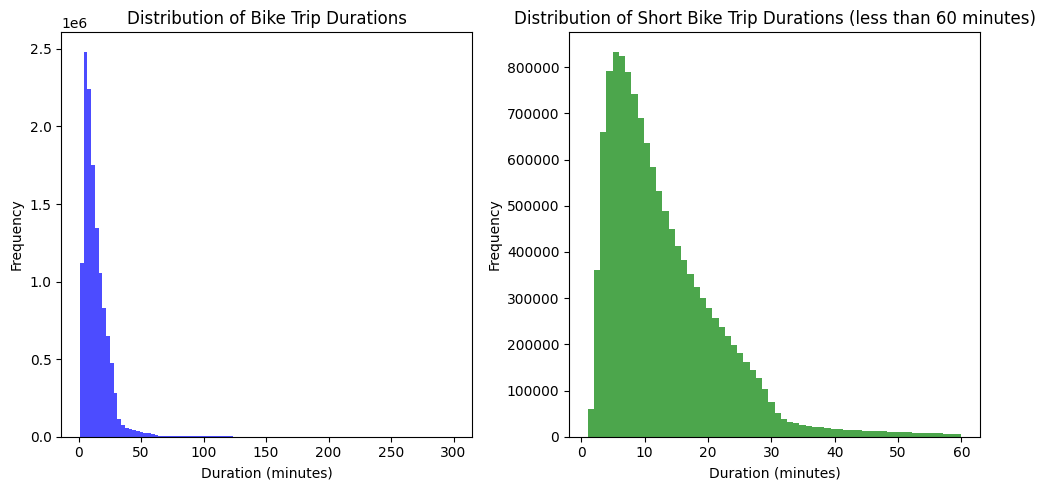

In [23]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(bike_df['Duration'], bins=100, color='blue', alpha=0.7)
ax[0].set_title('Distribution of Bike Trip Durations')
ax[0].set_xlabel('Duration (minutes)')
ax[0].set_ylabel('Frequency')
ax[1].hist(bike_df[bike_df['Duration'] < 60]['Duration'], bins=60, color='green', alpha=0.7)
ax[1].set_title('Distribution of Short Bike Trip Durations (less than 60 minutes)')
ax[1].set_xlabel('Duration (minutes)')
ax[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

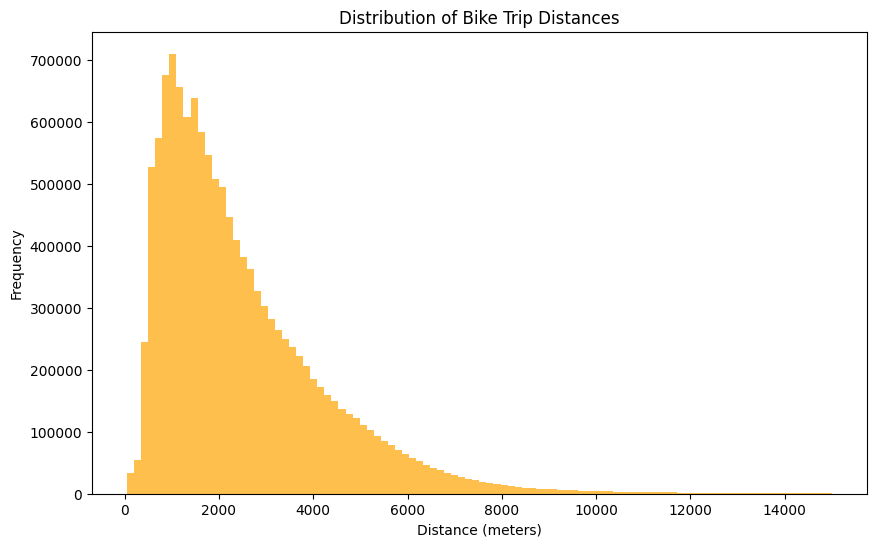

In [20]:
bike_df['Distance'].plot(kind='hist', bins=100, figsize=(10, 6), color='orange', alpha=0.7)
plt.title('Distribution of Bike Trip Distances')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
hourly_usage = bike_df.groupby([pd.Grouper(key='Departure', freq='h')]).size().reset_index(name='Count').set_index('Departure')

Count    0
dtype: int64

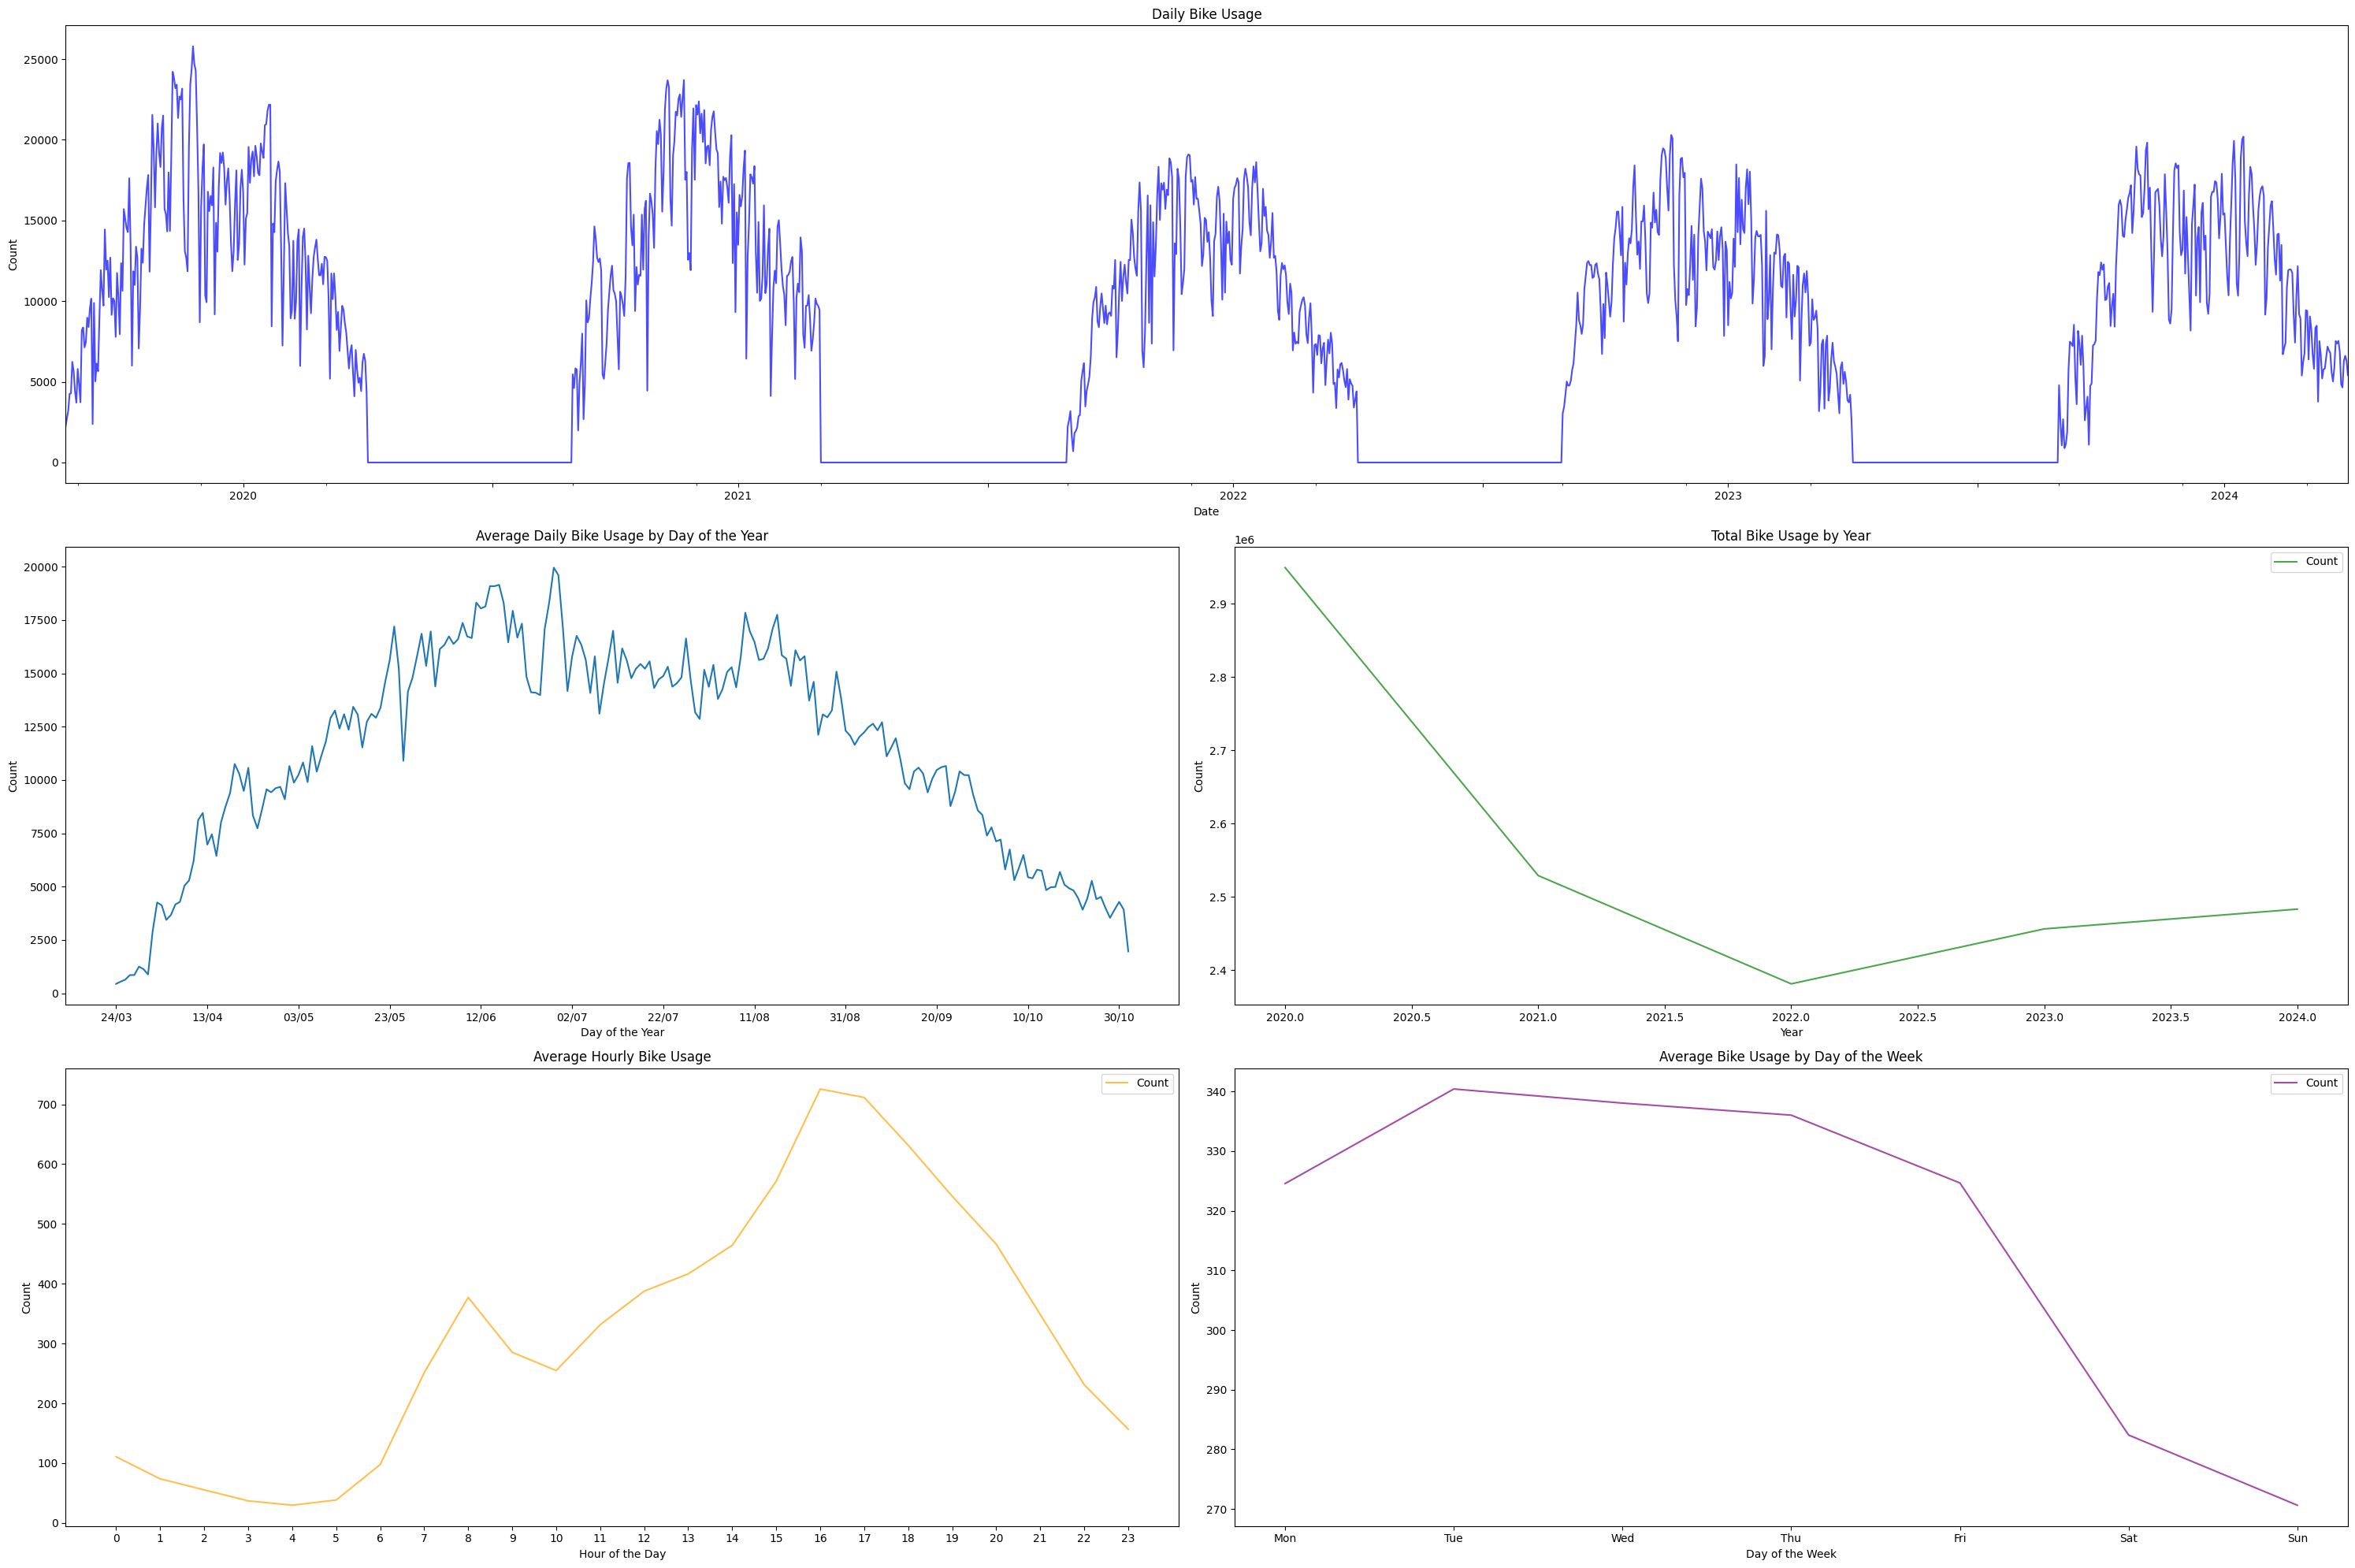

In [48]:
f, ax = plt.subplot_mosaic("AA;BC;DE", figsize=(30,20))
df_daily = hourly_usage.resample('D').sum()
df_daily['Count'].plot(ax=ax['A'], color='blue', alpha=0.7)
ax["A"].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax["A"].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
[l.set_visible(False) for (i,l) in enumerate(ax["A"].xaxis.get_ticklabels()) if i % 2 != 0]
ax['A'].set_title('Daily Bike Usage')
ax['A'].set_xlabel('Date')
ax['A'].set_ylabel('Count')

day_of_year_mean = df_daily.groupby(df_daily.index.dayofyear).mean()
day_of_year_mean.index = pd.to_datetime(day_of_year_mean.index, format='%j').strftime('%d/%m')
ax['B'].plot(day_of_year_mean[day_of_year_mean['Count'] > 0])
ax["B"].xaxis.set_major_locator(plt.MaxNLocator(14))
ax['B'].set_title('Average Daily Bike Usage by Day of the Year')
ax['B'].set_xlabel('Day of the Year')
ax['B'].set_ylabel('Count')

hourly_usage.groupby([hourly_usage.index.year]).sum().plot(ax=ax['C'], color='green', alpha=0.7)
ax['C'].set_title('Total Bike Usage by Year')
ax['C'].set_xlabel('Year')
ax['C'].set_ylabel('Count') 

hourly_usage.groupby([hourly_usage.index.hour]).mean().plot(ax=ax['D'], color='orange', alpha=0.7)
ax["D"].set_xticks(np.arange(0,24))
ax['D'].set_title('Average Hourly Bike Usage')
ax['D'].set_xlabel('Hour of the Day')
ax['D'].set_ylabel('Count')

hourly_usage.groupby([hourly_usage.index.weekday]).mean().plot(ax=ax['E'], color='purple', alpha=0.7)
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax['E'].set_xticks(range(7))
ax['E'].set_xticklabels(weekdays)
ax['E'].xaxis.set_major_locator(plt.MaxNLocator(7))
ax['E'].set_title('Average Bike Usage by Day of the Week')
ax['E'].set_xlabel('Day of the Week')
ax['E'].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [43]:
hourly_usage.groupby([hourly_usage.index.year]).sum()

,Count
Departure,
2020,2949239
2021,2529039
2022,2381247
2023,2456238
2024,2483207
